In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train Phase transformations
# train_transforms = transforms.Compose([
#                                       A.ShiftScaleRotate(shift_limit = 0.05, p = 0.5),
#                                       A.HorizontalFlip(p=0.5),
#                                       A.CoarseDropout(max_holes=1, max_height=16, max_width=16,
#                                       min_holes=1, min_height=16, min_width=16,
#                                       fill_value=(0.4914, 0.4822, 0.4465),
#                                       mask_fill_value=None),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#                                        ])
albu_transforms = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std= (0.2023, 0.1994, 0.2010)),
    A.ShiftScaleRotate(shift_limit=0.05, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16,
                    min_holes=1, min_height=16, min_width=16,
                    fill_value=(0.4914, 0.4822, 0.4465),
                    mask_fill_value=None),
    A.Resize(32, 32),
    ToTensorV2(),
])
def albu_transform(image):
    # Convert PIL image to numpy array
    image_np = np.array(image)
    # Apply Albumentations transforms
    transformed = albu_transforms(image=image_np)
    return transformed['image']

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=albu_transform)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:10<00:00, 15562067.72it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


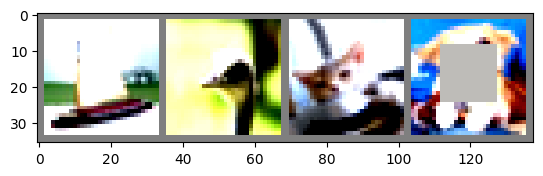

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
# !pip install torchsummary

In [7]:
import torch.nn.functional as F
from torchsummary import summary

dropout_value = 0.03
group_value = 4
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential( #32
            nn.Conv2d(3, 32, 3, padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(32),

        )
        self.conv2 = nn.Sequential( #32
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        #tb
        self.conv3 = nn.Sequential( #32
            nn.Conv2d(64, 32, 3, padding=1, bias=False, stride = 2),
        )
        ##BLOCK2
        self.conv4 = nn.Sequential( #32
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv5 = nn.Sequential( #32
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        #tb
        self.conv6 = nn.Sequential( #32
            nn.Conv2d(64, 32, 3, padding=1, bias=False, stride= 2), #keeping the padding 'same'
        )

        ##BLOCK3
        self.conv7 = nn.Sequential( #32
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        self.conv9 = nn.Sequential( #not using tb here coz we're so close to output.
            nn.Conv2d(64, 32, 3, padding=1, bias=False, stride = 2),
        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.gap(x)
        x = self.conv10(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 32, 16, 16]          18,432
            Conv2d-8           [-1, 64, 16, 16]          18,432
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,864
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
           Conv2d-14             [

In [8]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []  # List to store misclassified images and labels
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)  # Remove keepdim=True; now shape: [batch_size]
            correct += pred.eq(target).sum().item()

            # Find misclassified indices
            misclassified_idxs = (pred != target).nonzero(as_tuple=False).squeeze()
            for idx in misclassified_idxs:
                if len(misclassified_images) < 10:  # Collect only 10 images
                    img = data[idx].cpu()
                    actual_label = target[idx].item()
                    predicted_label = pred[idx].item()
                    misclassified_images.append((img, predicted_label, actual_label))
                else:
                    break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, Accuracy


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience = 20)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    # test(model, device, test_loader)
    misclassified_images, Accuracy = test(model, device, test_loader)
    scheduler.step(Accuracy)


EPOCH: 0


Loss=1.6103644371032715 Batch_id=97 Accuracy=30.72: 100%|██████████| 98/98 [00:15<00:00,  6.21it/s]



Test set: Average loss: 1.5183, Accuracy: 4346/10000 (43.46%)

EPOCH: 1


Loss=1.5422688722610474 Batch_id=97 Accuracy=44.04: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]



Test set: Average loss: 1.3347, Accuracy: 5143/10000 (51.43%)

EPOCH: 2


Loss=1.31900155544281 Batch_id=97 Accuracy=50.42: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 1.1633, Accuracy: 5838/10000 (58.38%)

EPOCH: 3


Loss=1.2453490495681763 Batch_id=97 Accuracy=54.35: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 1.1424, Accuracy: 5942/10000 (59.42%)

EPOCH: 4


Loss=1.16348397731781 Batch_id=97 Accuracy=57.34: 100%|██████████| 98/98 [00:14<00:00,  6.57it/s]



Test set: Average loss: 1.0197, Accuracy: 6405/10000 (64.05%)

EPOCH: 5


Loss=0.9994099140167236 Batch_id=97 Accuracy=59.78: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]



Test set: Average loss: 0.9141, Accuracy: 6804/10000 (68.04%)

EPOCH: 6


Loss=1.0157376527786255 Batch_id=97 Accuracy=61.81: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]



Test set: Average loss: 0.8730, Accuracy: 7005/10000 (70.05%)

EPOCH: 7


Loss=1.0342215299606323 Batch_id=97 Accuracy=63.79: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Test set: Average loss: 0.8289, Accuracy: 7076/10000 (70.76%)

EPOCH: 8


Loss=1.0931159257888794 Batch_id=97 Accuracy=65.05: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.7884, Accuracy: 7249/10000 (72.49%)

EPOCH: 9


Loss=0.9041563868522644 Batch_id=97 Accuracy=66.61: 100%|██████████| 98/98 [00:14<00:00,  6.54it/s]



Test set: Average loss: 0.7856, Accuracy: 7255/10000 (72.55%)

EPOCH: 10


Loss=0.9504402875900269 Batch_id=97 Accuracy=67.66: 100%|██████████| 98/98 [00:15<00:00,  6.53it/s]



Test set: Average loss: 0.6981, Accuracy: 7564/10000 (75.64%)

EPOCH: 11


Loss=0.9775446653366089 Batch_id=97 Accuracy=68.72: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 0.6747, Accuracy: 7674/10000 (76.74%)

EPOCH: 12


Loss=0.911841094493866 Batch_id=97 Accuracy=69.57: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.6800, Accuracy: 7660/10000 (76.60%)

EPOCH: 13


Loss=0.8470240235328674 Batch_id=97 Accuracy=70.27: 100%|██████████| 98/98 [00:15<00:00,  6.46it/s]



Test set: Average loss: 0.6758, Accuracy: 7650/10000 (76.50%)

EPOCH: 14


Loss=0.9206192493438721 Batch_id=97 Accuracy=70.74: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.6473, Accuracy: 7785/10000 (77.85%)

EPOCH: 15


Loss=0.8710511326789856 Batch_id=97 Accuracy=71.72: 100%|██████████| 98/98 [00:15<00:00,  6.36it/s]



Test set: Average loss: 0.6059, Accuracy: 7935/10000 (79.35%)

EPOCH: 16


Loss=0.8554526567459106 Batch_id=97 Accuracy=72.17: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 0.5839, Accuracy: 7999/10000 (79.99%)

EPOCH: 17


Loss=0.7617983222007751 Batch_id=97 Accuracy=72.68: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 0.5969, Accuracy: 7990/10000 (79.90%)

EPOCH: 18


Loss=0.6733781695365906 Batch_id=97 Accuracy=73.47: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Test set: Average loss: 0.5822, Accuracy: 7979/10000 (79.79%)

EPOCH: 19


Loss=0.8286722898483276 Batch_id=97 Accuracy=73.60: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.5546, Accuracy: 8093/10000 (80.93%)

EPOCH: 20


Loss=0.7603245973587036 Batch_id=97 Accuracy=73.88: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.5444, Accuracy: 8149/10000 (81.49%)

EPOCH: 21


Loss=0.7466880083084106 Batch_id=97 Accuracy=74.40: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 0.5581, Accuracy: 8088/10000 (80.88%)

EPOCH: 22


Loss=0.7707086205482483 Batch_id=97 Accuracy=74.91: 100%|██████████| 98/98 [00:15<00:00,  6.48it/s]



Test set: Average loss: 0.5351, Accuracy: 8157/10000 (81.57%)

EPOCH: 23


Loss=0.7233379483222961 Batch_id=97 Accuracy=75.29: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.5333, Accuracy: 8165/10000 (81.65%)

EPOCH: 24


Loss=0.64485102891922 Batch_id=97 Accuracy=75.59: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.5180, Accuracy: 8246/10000 (82.46%)

EPOCH: 25


Loss=0.5981969833374023 Batch_id=97 Accuracy=75.99: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]



Test set: Average loss: 0.5417, Accuracy: 8127/10000 (81.27%)

EPOCH: 26


Loss=0.6262209415435791 Batch_id=97 Accuracy=76.26: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.5067, Accuracy: 8248/10000 (82.48%)

EPOCH: 27


Loss=0.6327357292175293 Batch_id=97 Accuracy=77.05: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.5147, Accuracy: 8284/10000 (82.84%)

EPOCH: 28


Loss=0.6811358332633972 Batch_id=97 Accuracy=76.59: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Test set: Average loss: 0.5128, Accuracy: 8242/10000 (82.42%)

EPOCH: 29


Loss=0.6623597145080566 Batch_id=97 Accuracy=77.10: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.4765, Accuracy: 8415/10000 (84.15%)

EPOCH: 30


Loss=0.7106614708900452 Batch_id=97 Accuracy=77.31: 100%|██████████| 98/98 [00:15<00:00,  6.45it/s]



Test set: Average loss: 0.4952, Accuracy: 8337/10000 (83.37%)

EPOCH: 31


Loss=0.7055672407150269 Batch_id=97 Accuracy=77.71: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.4843, Accuracy: 8362/10000 (83.62%)

EPOCH: 32


Loss=0.6619178056716919 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.4654, Accuracy: 8412/10000 (84.12%)

EPOCH: 33


Loss=0.6160411834716797 Batch_id=97 Accuracy=77.94: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.4556, Accuracy: 8419/10000 (84.19%)

EPOCH: 34


Loss=0.5330333113670349 Batch_id=97 Accuracy=78.24: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.4724, Accuracy: 8382/10000 (83.82%)

EPOCH: 35


Loss=0.6146851778030396 Batch_id=97 Accuracy=78.30: 100%|██████████| 98/98 [00:14<00:00,  6.55it/s]



Test set: Average loss: 0.4649, Accuracy: 8417/10000 (84.17%)

EPOCH: 36


Loss=0.5783340930938721 Batch_id=97 Accuracy=78.62: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]



Test set: Average loss: 0.4812, Accuracy: 8375/10000 (83.75%)

EPOCH: 37


Loss=0.6068971157073975 Batch_id=97 Accuracy=78.78: 100%|██████████| 98/98 [00:15<00:00,  6.50it/s]



Test set: Average loss: 0.4729, Accuracy: 8435/10000 (84.35%)

EPOCH: 38


Loss=0.6242190599441528 Batch_id=97 Accuracy=78.64: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.4564, Accuracy: 8468/10000 (84.68%)

EPOCH: 39


Loss=0.6483412981033325 Batch_id=97 Accuracy=79.24: 100%|██████████| 98/98 [00:15<00:00,  6.41it/s]



Test set: Average loss: 0.4776, Accuracy: 8409/10000 (84.09%)

EPOCH: 40


Loss=0.6022270321846008 Batch_id=97 Accuracy=79.11: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.4472, Accuracy: 8473/10000 (84.73%)

EPOCH: 41


Loss=0.5737578272819519 Batch_id=97 Accuracy=79.21: 100%|██████████| 98/98 [00:15<00:00,  6.40it/s]



Test set: Average loss: 0.4325, Accuracy: 8514/10000 (85.14%)

EPOCH: 42


Loss=0.5447701811790466 Batch_id=97 Accuracy=79.52: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 0.4341, Accuracy: 8525/10000 (85.25%)

EPOCH: 43


Loss=0.5815131068229675 Batch_id=97 Accuracy=79.54: 100%|██████████| 98/98 [00:15<00:00,  6.44it/s]



Test set: Average loss: 0.4629, Accuracy: 8424/10000 (84.24%)

EPOCH: 44


Loss=0.6321640014648438 Batch_id=97 Accuracy=79.39: 100%|██████████| 98/98 [00:15<00:00,  6.39it/s]



Test set: Average loss: 0.4354, Accuracy: 8523/10000 (85.23%)

EPOCH: 45


Loss=0.6443799138069153 Batch_id=97 Accuracy=80.08: 100%|██████████| 98/98 [00:15<00:00,  6.38it/s]



Test set: Average loss: 0.4394, Accuracy: 8535/10000 (85.35%)

EPOCH: 46


Loss=0.47027257084846497 Batch_id=97 Accuracy=80.08: 100%|██████████| 98/98 [00:15<00:00,  6.26it/s]



Test set: Average loss: 0.4333, Accuracy: 8527/10000 (85.27%)

EPOCH: 47


Loss=0.669617772102356 Batch_id=97 Accuracy=80.22: 100%|██████████| 98/98 [00:15<00:00,  6.30it/s]



Test set: Average loss: 0.4488, Accuracy: 8503/10000 (85.03%)

EPOCH: 48


Loss=0.5628031492233276 Batch_id=97 Accuracy=80.41: 100%|██████████| 98/98 [00:15<00:00,  6.37it/s]



Test set: Average loss: 0.4211, Accuracy: 8588/10000 (85.88%)

EPOCH: 49


Loss=0.5199568867683411 Batch_id=97 Accuracy=80.44: 100%|██████████| 98/98 [00:15<00:00,  6.43it/s]



Test set: Average loss: 0.4320, Accuracy: 8564/10000 (85.64%)



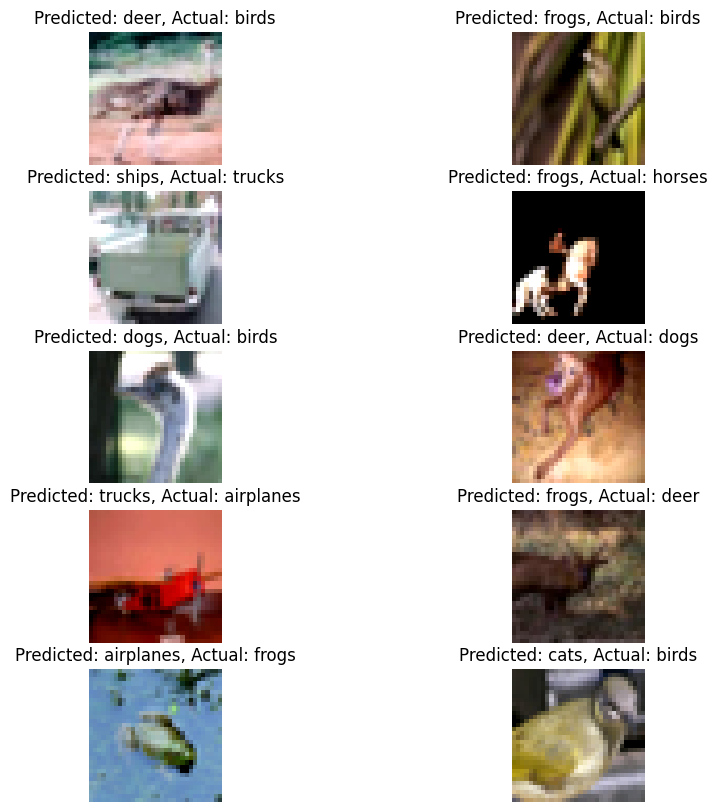

In [ ]:
import matplotlib.pyplot as plt

def visualize_misclassified_images(misclassified_images):
    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    plt.figure(figsize=(10, 10)) #original images were 32x32
    for i, (image, pred, actual) in enumerate(misclassified_images[:10]):
        image = image.numpy().transpose(1, 2, 0)  # Convert to (height, width, channel)
        mean = [0.4914, 0.4822, 0.4465] #3 values for 2 channels, RGB
        std = [0.247, 0.243, 0.261]
        image = image * std + mean  # Undo normalization
        image = np.clip(image, 0, 1)  # Clip values to valid range

        plt.subplot(5, 2, i+1)
        plt.imshow(image)

        plt.title(f"Predicted: {classes[pred]}, Actual: {classes[actual]}")
        plt.axis('off')
    plt.show()

visualize_misclassified_images(misclassified_images)


In [ ]:
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
t = [train_items.item() for train_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

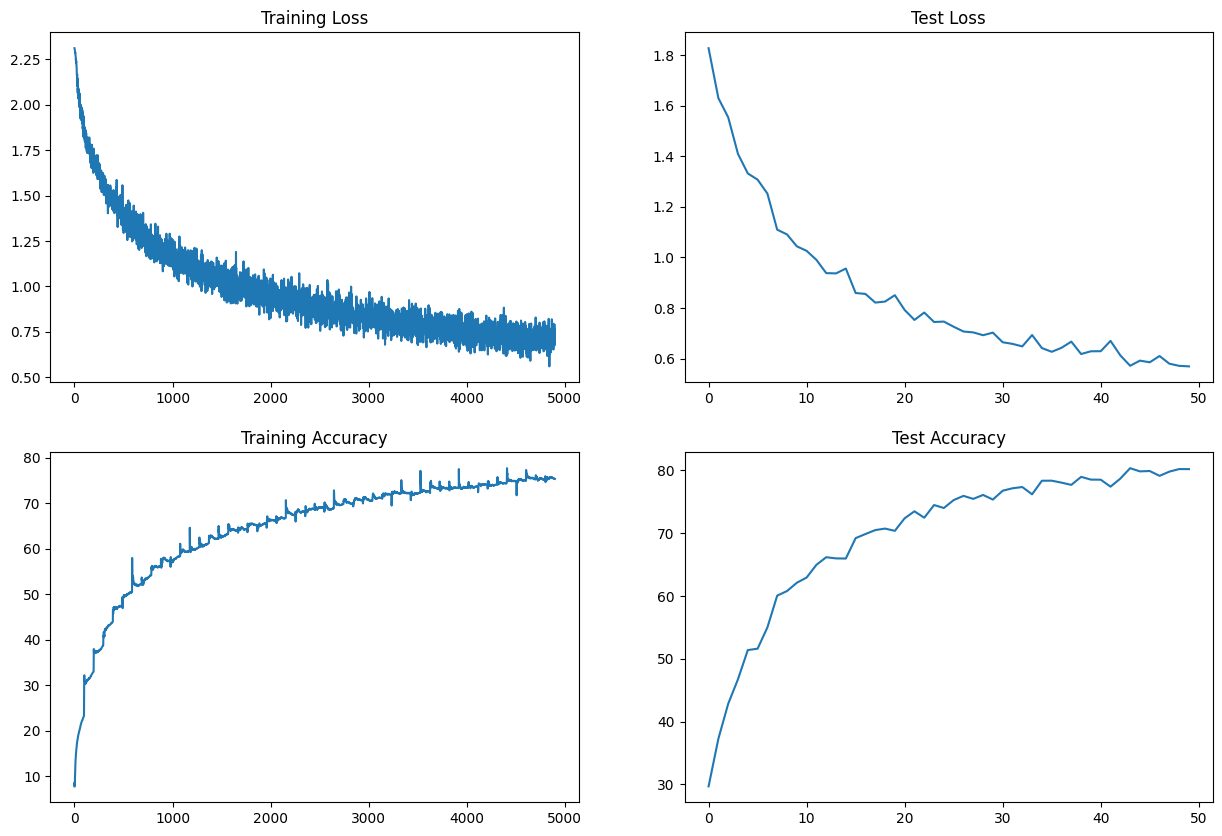

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers


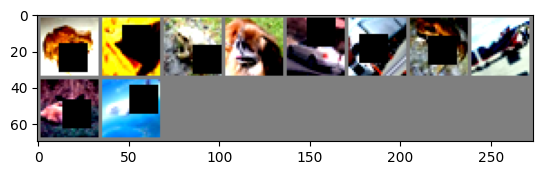

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

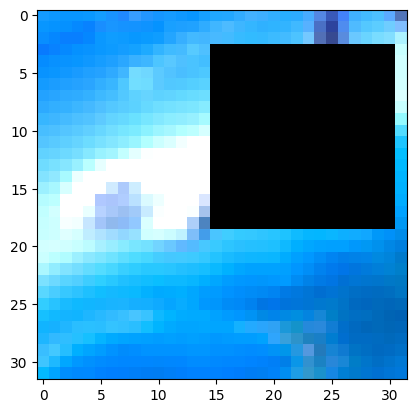

In [ ]:
image = images[9]
imshow(image)

In [ ]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

10
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 36, 36])
torch.Size([1, 64, 36, 36])
torch.Size([1, 64, 36, 36])
torch.Size([1, 32, 40, 40])
torch.Size([1, 64, 40, 40])
torch.Size([1, 64, 40, 40])
torch.Size([1, 32, 44, 44])
torch.Size([1, 10, 44, 44])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(36, 36)
(36, 36)
(36, 36)
(40, 40)
(40, 40)
(40, 40)
(44, 44)
(44, 44)


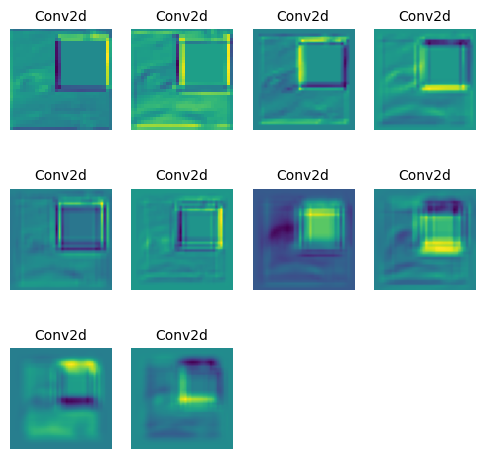

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

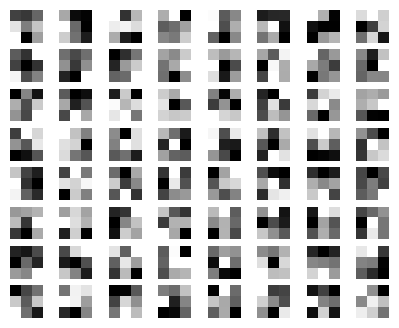

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()